In [76]:
import qcluster 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, copy
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram, plot_distribution
import importlib
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

### Demonstration of Q-Cluster on Bit-Flip noise model 

Below we demonstrate how to use Q-Cluster iterative approach on the bitflip noise model

In [ ]:
idl = {"01"*5: 8192, "1"*10: 8192}
idl = qcluster.multiply_dict(idl, 1)
nsm = qcluster.random_bitflip(idl, 0.1)
print("Fidelity of the noisy distribution: ", qcluster.qcluster.qcluster.hellinger_fidelity(idl, nsm))

Fidelity of the noisy distribution:  0.3559797622798368


Lets mitigate now:


In [74]:
# Note: Ensure that the noisy distribution is not normalized. If the distribution is normalized, you can use 
# qcluster.multiply_dict(nsm, shots) to scale it back to the original distribution.
importlib.reload(qcluster)
km = qcluster.QCluster(max_clusters=2**10, n = 10, tol = 0.9, prob = 0.1)
mitig = km.fit(nsm)
print("Fidelity of the mitigated distribution: ", qcluster.hellinger_fidelity(idl, mitig))

Fidelity of the mitigated distribution:  0.8118617021479508


### Estimation of error rate
The code below shows comparison of several ML models on circuit data 

In [77]:
# Import file containing features of circuits to predict error rate
data = qcluster.load_object("../data/training_20250307_2151.pkl")
columns = ['Machine', 'Algorithm', 'Qubit', 'Measure', 'rz', 'sx', 'x', 'ecr', 'entropy', 'esp_m', 'ip Entropy', 'Target']
df = pd.DataFrame(data, columns=columns)
df = df.dropna()
#df = df[df['Machine'] != ('ibm_torino')]
# Selecting features (columns 3-10)
X = df.iloc[:, 2:10]  
y = df.iloc[:, 11]  

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=40)

# Define different regressors to test
regressors = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "DecisionTree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "SVR": SVR(kernel='rbf', C=100, gamma=0.1),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
}

# Store results
results = {reg: {"MSE": [], "R2": []} for reg in regressors}

# Perform K-Fold Cross Validation for each model
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for name, model in regressors.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[name]["MSE"].append(mse)
        results[name]["R2"].append(r2)

# Compute average scores across all folds
for name in regressors:
    avg_mse = np.mean(results[name]["MSE"])
    avg_r2 = np.mean(results[name]["R2"])
    print(f"{name} - Average MSE: {avg_mse:.4f}, Average R²: {avg_r2:.4f}")

RandomForest - Average MSE: 0.0006, Average R²: 0.9535
GradientBoosting - Average MSE: 0.0006, Average R²: 0.9517
ExtraTrees - Average MSE: 0.0005, Average R²: 0.9643
DecisionTree - Average MSE: 0.0010, Average R²: 0.9229
SVR - Average MSE: 0.0126, Average R²: -0.0199
KNN - Average MSE: 0.0026, Average R²: 0.8014
XGBoost - Average MSE: 0.0006, Average R²: 0.9452


Text(0.5, 1.0, 'Average Feature Importances Across K-Folds')

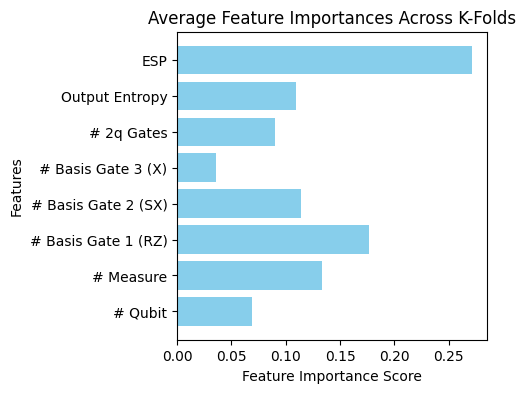

In [ ]:
import matplotlib.pyplot as plt

data = qcluster.load_object("../data/training_20250307_2151.pkl")
columns = ['Machine', 'Algorithm', '# Qubit', '# Measure', '# Basis Gate 1 (RZ)', '# Basis Gate 2 (SX)', '# Basis Gate 3 (X)', '# 2q Gates', 'Output Entropy', 'ESP', 'ip Entropy', 'Target']
#columns = ['Machine', 'Algorithm', '# Qubits', '# Measured Qubits', '# 1q Gates', '# 2q Gates', 'Entropy', 'ESP', 'ip Entropy', 'Target']
df = pd.DataFrame(data, columns=columns)
#print("HERE")
df = df.dropna()
#df = df[df['Machine'] != ('ibm_torino')]
# Selecting features (columns 3-10)
X = df.iloc[:, 2:10]  
y = df.iloc[:, 11]  

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=40)
feature_importances = np.zeros(len(X.columns))
# Initialize lists to store results
mse_scores = []
r2_scores = []
mse_o_scores = []
mlist = []
# Perform K-Fold Cross Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    mlist.append(model)
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)  # MSE with Feature9 as baseline

    # Store results
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    feature_importances += model.feature_importances_

# Compute average feature importance across folds
feature_importances /= kf.get_n_splits()

plt.figure(figsize=(4, 4))
plt.barh(X.columns, feature_importances, color='skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Average Feature Importances Across K-Folds')

### Example execution Q-Cluster, overestimated Q-Cluster, Q-Cluster with clusters on real machine data

Below is the code for ibm_brussels data for 

Benchmarks
1. ghz_state_n11
2. ghz_state_n23
3. bv_n14
4. bv_n19
5. cat_state_n22
6. wstate_n3 
7. wstate_n27



In [95]:
importlib.reload(qcluster)
master_dict = qcluster.load_object("../data/master_dict_ibm_brussels_new_20250307_2151.pkl")
import time
ii = 0
res_d = {}
flag = True
data = qcluster.load_object("../data/training_20250307_2151.pkl")

columns = ['Machine', 'Algorithm', 'Qubit', 'Measure', 'rz', 'sx', 'x', 'ecr', 'entropy', 'esp_m', 'ip Entropy', 'Target']

df = pd.DataFrame(data, columns=columns)
df = df.dropna()
X = df.iloc[:, 2:10]  
y = df.iloc[:, 11]  

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)


mlist = []
# Perform K-Fold Cross Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    mlist.append(model)

print("Index", "Algorithm", "Noisy", "Q-Cluster exact", "Q-Cluster 25 pc", "Q-Cluster 50 pc", "Q-Cluster exact clus", "Improvement exact", "Improvement 25 pc", "Improvement 50 pc", "Improvement exact clus")
for train_index, test_index in kf.split(df):
    X_test = df.iloc[test_index]
    mdl = mlist[ii]
    ii += 1
    X_pred = X_test.iloc[:, 2:10]
    y_pred = mdl.predict(X_pred)
    for idxx, (index, row) in enumerate(X_test.iterrows()):
        
        sttime = time.time()
        idict = {}
        mach = row['Machine']
        alg = row['Algorithm']
        if row['ip Entropy'] > 0.6:
            continue
        if mach != 'ibm_brussels':
            continue
        dc = master_dict
        if alg not in dc:
            continue
        idl = dc[alg]['ideal']
        nsm = dc[alg]['nsm']
        p = row['Target'] # Error rate as calculate from ideal and noisy distribution
        p2 = y_pred[idxx] # Error rate as estimated by the ExtraTrees model
        circ = dc[alg]['circ']
               
        cn = qcluster.multiply_dict(copy.deepcopy(nsm), dc[alg]['shots'])
        
        
        km = qcluster.QCluster(1024, row['Measure'], prob= p2, init_method="top_k", mul=2.0, tol=0.95)
        km.fit(copy.deepcopy(cn))       
        of = qcluster.hellinger_fidelity(qcluster.renormalize(idl), qcluster.renormalize(km.labels_))
        
        km1 = qcluster.QCluster(1024, row['Measure'], prob= (p2 + 0.25*p2), init_method="top_k", mul=2.0, tol=0.95)
        km1.fit(copy.deepcopy(cn))
        of1 = qcluster.hellinger_fidelity(qcluster.renormalize(idl), qcluster.renormalize(km1.labels_))

        start_time = time.time()
        km2 = qcluster.QCluster(1024, row['Measure'], prob= (p2 + 0.50*p2), init_method="top_k", mul=2.0, tol=0.95)
        km2.fit(copy.deepcopy(cn))
        of2 = qcluster.hellinger_fidelity(qcluster.renormalize(idl), qcluster.renormalize(km2.labels_))
        
        if int(len(list(idl.keys()))) < 200: # to save time, get rid for large circuits
            km3 = qcluster.QCluster(1024, row['Measure'], prob= p2, init_method="top_k", mul=2.0, tol=0.95)
            km3.fit_x(copy.deepcopy(cn), int(len(list(idl.keys()))))
            of3 = qcluster.hellinger_fidelity(qcluster.renormalize(idl), qcluster.renormalize(km3.labels_))
        else:
            of3 = np.nan
        
        idict['machine'] = mach
        idict['Algorithm'] = alg
        idict['entropy'] = qcluster.shannon_entropy_from_dict(copy.deepcopy(qcluster.renormalize(idl)))
        idict['esp'] = dc[alg]['esp_m']
        idict['p'] = p
        idict['p2'] = p2
        idict['actualerr'] = row['Target']
        idict['Noisy'] = qcluster.hellinger_fidelity(qcluster.renormalize(idl), qcluster.renormalize(nsm))
        idict['Q-Cluster exact'] = of
        idict['Q-Cluster 25 pc'] = of1
        idict['Q-Cluster 50 pc'] = of2
        idict['Q-Cluster exact clus'] = of3
        
        
        res_d[mach + alg] = idict
        print(index, alg, idict['Noisy'], of, of1, of2, of3, (of+0.01)/(idict['Noisy']+0.01), (of1+0.01)/(idict['Noisy']+0.01), (of2+0.01)/(idict['Noisy']+0.01), (of3+0.01)/(idict['Noisy']+0.01))

Index Algorithm Noisy Q-Cluster exact Q-Cluster 25 pc Q-Cluster 50 pc Q-Cluster exact clus Improvement exact Improvement 25 pc Improvement 50 pc Improvement exact clus
42 ghz_state_n11 0.45014237525213097 0.7075127946807929 0.7168653314225565 0.759067985169022 0.7075127946807929 1.5593277934631384 1.5796531041599398 1.6713696163010805 1.5593277934631384
51 wstate_n3 0.8571553242174283 0.8896514085716059 0.897311592454253 0.904780430437024 0.9586137908402981 1.037474352571731 1.0463080455315938 1.0549210791764156 1.1170014918774
34 bv_n14 0.027465820312500076 0.08020506049063893 0.08028605538802991 0.07596709996920169 0.518160888387641 2.4076627640405075 2.4098245983928694 2.2945473835126373 14.09713931210591
47 bv_n19 0.0017089843750000312 0.06719271002499523 0.07142224524900773 0.06908689620115649 0.4474196108185847 6.592605093043778 6.953826449956938 6.754377123434864 39.06569486890989
49 wstate_n27 0.012969101227724376 0.06910382200832725 0.0797143345842372 0.0953049580105824 0.0927